# Unsupervised Learning: Marketing Analytics - Customer Segmentation

## Skills: Kmeans Clustering, Mining Time Series Transaction Data, RFM Analysis 

Market segmentation allows companies to get a better understanding of thier customer characteristics and therefore can tailor marketing campaigns to each customer segment.  One of the most popular segmentation method is RFM analysis.  RFM stands for Recency, Frequency, and Monetary value. These RFM metrics are important indicators of a customer’s behavior because frequency and monetary value affects a customer’s lifetime value, and recency affects retention, a measure of engagement.

This project applies RFM analysis in mining time series transaction data from a retail bank for the purpose of customer segmentation.  12 months of transaction record is extracted for segmentaion (May 2018 to April 2019).  Each record is aggregated to the monthly level.  It also has a customer profile dataset which contains static features like age, open date etc.

In [1]:
#Import libraries necessary for this project
import numpy as np
import pandas as pd
from numpy import unique
from pandas import read_csv
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

# Graphic display for notebooks
%matplotlib inline

In [10]:
#Loading Customer Profile Data
Profile = read_csv('/Users/hleung/PycharmProjects/S6a.csv', header=0)
Profile.shape

(34812, 11)

The dataset has a sample of 34812 customers and 11 features.

## Profile Data

In [11]:
Profile.head(5)

,Memberid,Status,OpenDate,CloseDate,Age,NumberofSavingsProducts,CountofLoans,TenureMonth,DBINDICATOR,CCINDICATOR,INDIRECT
0,4444R4MGG,Open,2017-08-18,NaN,80.0,1.0,1,23,0,0,1
1,444F4RR4K,Open,2017-11-17,NaN,31.0,1.0,1,20,0,0,0
2,444G55TMG,Open,2016-12-08,NaN,20.0,2.0,0,31,1,0,0
3,444RMTMGF,Open,2018-02-15,NaN,31.0,1.0,1,17,0,0,1
4,444ZZ88RM,Open,2018-10-19,NaN,62.0,2.0,0,9,1,0,0


In [12]:
# Feature Description:
# Memberid: A unique customer id
# Status: Open / Closed depends on whether th customer has closed the account or not
# OpenDate, Close Date: The time when the customer open or close the account
# Age: Customer age
# NumberofSavingsProducts: No. of savings products the customer is having in the bank
# CountofLoans: No. of Loans the customer is having in the bank
# TenureMonth: The length of time in months the customer is with the bank
# DBINDICATOR: Whether the customer has a debit card with the bank (1 or 0)
# CCINDICATOR: Whether the customer has a credit card with the bank (1 or 0)
# INDIRECT: Whether the customer has an indirect loan with the bank (1 or 0)

In [17]:
Profile.describe()

,Age,NumberofSavingsProducts,CountofLoans,TenureMonth,DBINDICATOR,CCINDICATOR,INDIRECT
count,34738.000000,34810.000000,34812.000000,34812.000000,34812.000000,34812.000000,34812.000000
mean,37.704186,1.713444,0.407963,19.127628,0.585516,0.104102,0.301218
std,19.283091,0.732845,0.547219,8.232303,0.492640,0.305397,0.458794
min,0.000000,1.000000,0.000000,7.000000,0.000000,0.000000,0.000000
25%,22.000000,1.000000,0.000000,12.000000,0.000000,0.000000,0.000000
50%,36.000000,2.000000,0.000000,18.000000,1.000000,0.000000,0.000000
75%,52.000000,2.000000,1.000000,26.000000,1.000000,0.000000,1.000000
max,113.000000,10.000000,4.000000,35.000000,1.000000,1.000000,1.000000


Most customers are below the age of 50.  They have more savings products than loans.  They are with the bank for more than a year and a half.  Half of them have debit cards but only 10% has credt cards.  30% of them have indrect loans.

# Data Exploration

(-0.05500000000000001,
 0.05500000000000001,
 -0.05500000000000001,
 0.05500000000000001)

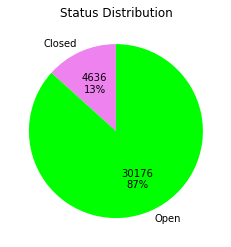

In [21]:
#Status Pie Chart
def label_function(val):
    return f'{val / 100 * len(Profile):.0f}\n{val:.0f}%'

Profile.groupby('Status').size().plot(kind='pie', autopct=label_function, startangle=90,
                                 colors=['violet', 'lime'])
labels = 'Active', 'Closed'
ax1.set_ylabel('Status', size=22)
plt.ylabel("")
plt.title('Status Distribution')
ax1.axis('equal')

The above pie chart shows the majority of customers choose to stay with the bank, there are only 4636 churn cases (13%) over the 3 year period.

Text(0, 0.5, 'No of Customers')

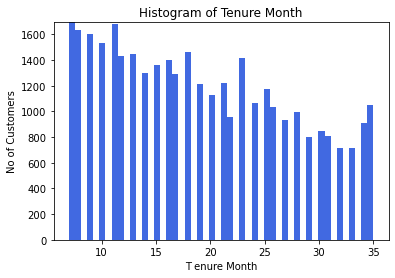

In [23]:
data = Profile['TenureMonth']
hx, hy, _ = plt.hist(data, bins=50, color="royalblue")
plt.ylim(0.0,max(hx)+0.05)
plt.title('Histogram of Tenure Month')
plt.xlabel("T enure Month")
plt.ylabel("No of Customers")

The above histogram shows there are more new customers than old customers, this is due to the bank's recruiting effort or customer churn.

## Transaction Data

In [11]:
#Loading Transaction Data

Tran = read_csv('/Users/hleung/PycharmProjects/S7p.csv', header=0)
Tran.shape

(671562, 16)

In [18]:
Tran.head(5)

,Memberid,Date,Status,Age,TenureMonth,NumberofDirectDeposits,SumofDirectDeposits,NumberofBillPayTransactions,NumberofDebitCardTransactions,NumberofTransactionsConductedinBranch,FEESCHARGED,SUMofFEESCHARGED,OnlineTran,NumberofPayments,SumofPaymentAmount,AllTran
0,584488448,2018-01-31,0,67.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0
1,584488448,2018-02-28,0,67.0,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,1.0
2,584488448,2018-03-31,0,67.0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0
3,584488448,2018-04-30,0,67.0,4,0.0,0.0,0.0,0.0,2.0,0.0,0.0,NaN,NaN,NaN,2.0
4,584488448,2018-05-31,0,67.0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0


This transaction dataset contains all monthly transaction records.  The number of rows each customer has depnds on the tenure month.  The first row of each customer is the start date and the last row is the close date (if the customer churns) or the cutoff date when the dataset was created (if the account is open).

In [19]:
#Feature Description (selected)
#Status: 0-active, 1-the month before churn, 2-churn
#FEESCHARGED - No. of times service fee is charged
#Online Tran - No. of online transactions
#NumberofPayments - No. of loan payments
#SumofPaymentAmount - Sum of loan payments
#AllTran - Total no. of transactions in that month

In [23]:
#Select long-term customers (TenureMonth >= 6) for clustering
cutoff1 = dt.datetime(2018, 11, 1) #6 months before last date of time frame.
cutoff2 = dt.datetime(2019, 5, 1) #last date of time frame
Profile['OpenDate'] = pd.to_datetime(Profile['OpenDate'])
Profile['CloseDate'] = pd.to_datetime(Profile['CloseDate'])

Open = Profile[(Profile['OpenDate'] <= cutoff1) & (Profile['Status'] == 'Open')] #Extract active customers
#Extract churn customers who close their accounts during the time frame
Close = Profile[(Profile['OpenDate'] <= cutoff1) & (Profile['CloseDate'] >= cutoff2)] 
Profile6 = pd.concat([Open, Close], ignore_index=True)
Profile6 = Profile6.sort_values(by=['Memberid'], ascending=True)
Profile6.shape

(28768, 11)

There are 28768 long-term customers.  Next, their transaction records are extracted for RFM analysis.

In [29]:
#Extract transaction records
namelist = Profile6['Memberid']
Tran6 = Tran[Tran['Memberid'].isin(namelist) == True]
Tran6.shape

(597039, 16)

# Feature Engineering - Creating RFM Features

## Recency

Recency gap is the time since last transaction, that is the time gap between last transaction and before target label is generated.  It indicates the freshness of customer activity.

In [33]:
Tran6 = Tran6.fillna(0) #fill missing values with 0 in all transaction records
Tran6['Date'] = pd.to_datetime(Tran6['Date'])
#Exclude months with no transaction and transactions after cutoff2
Tran6a = Tran6[(Tran6['AllTran'] != 0) & (Tran6['Date'] <= cutoff2)] 
Tran6b = Tran6a.groupby(['Memberid']).tail(1) #Select the last non-zero transaction month
Tran6b = Tran6b[['Memberid', 'Date']]
Tran6b = Tran6b.rename({'Date':'MostRecent'}, axis=1) #The column with last transaction month is named MostRecent
Profile6 = pd.merge(Profile6, Tran6b, on=['Memberid'], how='left') #merge to Profile6
# There are missing rows in MostRecent because those customers have no activities since Open Date, 
# replace Nan with OpenDate
Profile6.MostRecent = np.where(Profile6.MostRecent.isnull(), Profile6.OpenDate, Profile6.MostRecent)
Profile6['MostRecent'] = pd.to_datetime(Profile6['MostRecent'])

In [34]:
Profile6.head(5)

,Memberid,Status,OpenDate,CloseDate,Age,NumberofSavingsProducts,CountofLoans,TenureMonth,DBINDICATOR,CCINDICATOR,INDIRECT,MostRecent
0,4444R4MGG,Open,2017-08-18,NaT,80.0,1.0,1,23,0,0,1,2019-04-30
1,444F4RR4K,Open,2017-11-17,NaT,31.0,1.0,1,20,0,0,0,2019-04-30
2,444G55TMG,Open,2016-12-08,NaT,20.0,2.0,0,31,1,0,0,2017-07-31
3,444RMTMGF,Open,2018-02-15,NaT,31.0,1.0,1,17,0,0,1,2019-04-30
4,444ZZ88RM,Open,2018-10-19,NaT,62.0,2.0,0,9,1,0,0,2019-04-30


In [35]:
#A function calculate time gap between 2 dates in month
def months(d1, d2):
    return d1.month - d2.month + 12*(d1.year - d2.year)

#Calculate Recency Gap
gap = []
d1 = dt.datetime(2019, 4, 30) #the date before target label generation
for i in range (len(Profile6)):
    time_diff = months(d1, pd.to_datetime(Profile6.iloc[i, 11])) #gap between MostRecent and d1
    gap.append(time_diff)
    
Profile6['RecencyGap'] = gap

Text(0.5, 1.0, 'Cumulative Distribution of Customer Status by Recency Gap')

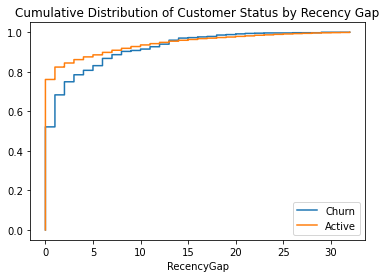

In [38]:
#Create cumulative frequency plots on recency gap
churn = Profile6[Profile6['Status'] == 'Closed']
ser1 = churn['RecencyGap'].squeeze()
ser1 = ser1.sort_values()
cum_dist1 = np.linspace(0.,1.,len(ser1))
ser_cdf1 = pd.Series(cum_dist1, index=ser1)

open = Profile6[Profile6['Status'] == 'Open']
ser2 = open['RecencyGap'].squeeze()
ser2= ser2.sort_values()
cum_dist2 = np.linspace(0.,1.,len(ser2))
ser_cdf2 = pd.Series(cum_dist2, index=ser2)

ser_cdf1.plot(drawstyle='steps')
ser_cdf2.plot(drawstyle='steps')
plt.legend(["Churn", "Active"], loc=4)
plt.title('Cumulative Distribution of Customer Status by Recency Gap')

The above plot shows active customers have a much shorter recency gap than churn customers.  90% of active customers have recency gap shorter than 9 months whereas 90% of churn customers have recency gap shorter than 13 months.

## Frequency, Monetary Values (Direct Deposit Amount and Loan Payment Amount)

Frequency is the number of all transactions within a year.  There are two features with monetary values in the transaction data: direct deposit amount and loan payment amount.

In [40]:
cutoff3 = dt.datetime(2018, 5, 1) #Beginning of the time frame
#Extract 12 months transaction data during the time frame
Tran6c = Tran6[(Tran6['Date'] < cutoff2) & (Tran6['Date'] >= cutoff3)] 
Tran6d = Tran6c[['Memberid', 'AllTran', 'SumofDirectDeposits', 'SumofPaymentAmount']]
Tran6d = Tran6d.groupby(['Memberid']).mean()
Tran6d = Tran6d.reset_index()
Tran6d = Tran6d.rename({'AllTran':'Freq', 'SumofDirectDeposits':'DDAmt', 'SumofPaymentAmount':'LoanPayAmt'}, axis=1)
Profile6 = pd.merge(Profile6, Tran6d, on=['Memberid'], how='left')

Text(0.5, 0, 'Average No of Transactions in a Month')

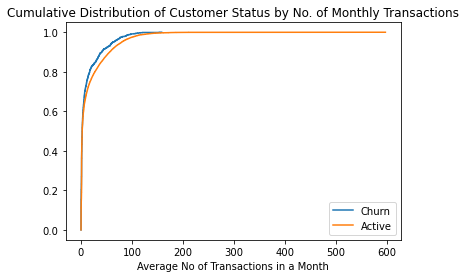

In [45]:
#Create cumulative frequency plots on frequency
churn = Profile6[Profile6['Status'] == 'Closed']
ser1 = churn['Freq'].squeeze()
ser1 = ser1.sort_values()
cum_dist1 = np.linspace(0.,1.,len(ser1))
ser_cdf1 = pd.Series(cum_dist1, index=ser1)

open = Profile6[Profile6['Status'] == 'Open']
ser2 = open['Freq'].squeeze()
ser2= ser2.sort_values()
cum_dist2 = np.linspace(0.,1.,len(ser2))
ser_cdf2 = pd.Series(cum_dist2, index=ser2)

ser_cdf1.plot(drawstyle='steps')
ser_cdf2.plot(drawstyle='steps')
plt.legend(["Churn", "Active"], loc=4)
plt.title('Cumulative Distribution of Customer Status by No. of Monthly Transactions')
plt.xlabel("Average No of Transactions in a Month")


The above plot shows a small group of active customers have over 200 transactions a month.  In the range of under 200 transactions, the proportion of churn customers is higher than active customers.  However, there are a large number of customers with almost no transaction in both categories.  Some of these dormant customers churn, many of them don't.

Text(0.5, 0, 'Average Monthly Direct Deposit')

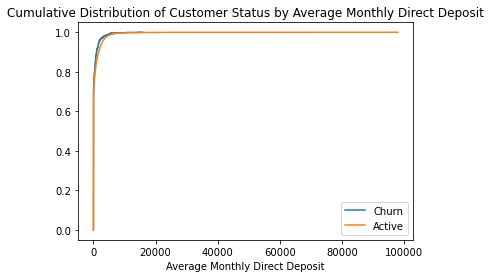

In [46]:
#Create cumulative frequency plots on Sum of Direct Deposit
ser1 = churn['DDAmt'].squeeze()
ser1 = ser1.sort_values()
cum_dist1 = np.linspace(0.,1.,len(ser1))
ser_cdf1 = pd.Series(cum_dist1, index=ser1)

ser2 = open['DDAmt'].squeeze()
ser2= ser2.sort_values()
cum_dist2 = np.linspace(0.,1.,len(ser2))
ser_cdf2 = pd.Series(cum_dist2, index=ser2)

ser_cdf1.plot(drawstyle='steps')
ser_cdf2.plot(drawstyle='steps')
plt.legend(["Churn", "Active"], loc=4)
plt.title('Cumulative Distribution of Customer Status by Average Monthly Direct Deposit')
plt.xlabel("Average Monthly Direct Deposit")

The above plot shows most customers do not have direct deposit transaction.  For those who do, active customers have a higher direct deposit amount than churn customers.

Text(0.5, 0, 'Average Monthly Loan Payment')

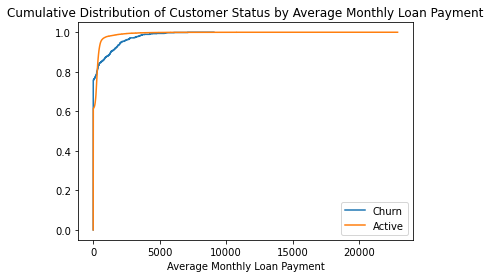

In [47]:
#Create cumulative frequency plots on Sum of Loan Payment
Profile6['LoanPayAmt'] = Profile6['LoanPayAmt'] * -1 #convert all entries to positive numbers
churn = Profile6[Profile6['Status'] == 'Closed']
ser1 = churn['LoanPayAmt'].squeeze()
ser1 = ser1.sort_values()
cum_dist1 = np.linspace(0.,1.,len(ser1))
ser_cdf1 = pd.Series(cum_dist1, index=ser1)

open = Profile6[Profile6['Status'] == 'Open']
ser2 = open['LoanPayAmt'].squeeze()
ser2= ser2.sort_values()
cum_dist2 = np.linspace(0.,1.,len(ser2))
ser_cdf2 = pd.Series(cum_dist2, index=ser2)

ser_cdf1.plot(drawstyle='steps')
ser_cdf2.plot(drawstyle='steps')
plt.legend(["Churn", "Active"], loc=4)
plt.title('Cumulative Distribution of Customer Status by Average Monthly Loan Payment')
plt.xlabel("Average Monthly Loan Payment")

Most customers have no loan payment.  For those who do, active customers have higher loan payment than churn customers.

## Customer Segmentation Using Kmeans Clustering

### Standardize Features

In [3]:
from sklearn.preprocessing import MinMaxScaler

RFM = pd.DataFrame(Profile6, columns=['Memberid', 'RecencyGap', 'Freq', 'DDAmt', 'LoanPayAmt'])
RFM = RFM.fillna(0) #fill all missing values with 0
id = RFM[['Memberid']]
RFM = RFM.set_index('Memberid')

In [4]:
#Standized all values
scaler = MinMaxScaler()
RFM1 = scaler.fit_transform(RFM)
RFM1 = pd.DataFrame(RFM1, columns = RFM.columns)
RFM1 = pd.concat([id, RFM1], axis=1)
RFM1 = RFM1.set_index('Memberid')

### Kmeans Clustering

In [5]:
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

Text(0.5, 1.0, 'Customer Segmentation: Sum of Square Error')

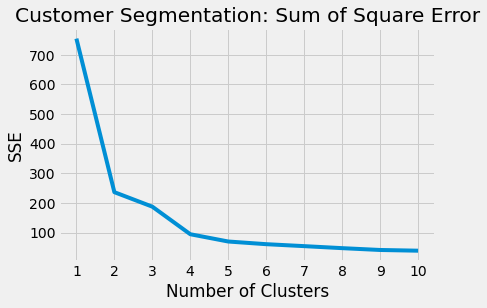

In [6]:
#elbow method to determine the number of clusters
kmeans_kwargs = {"init": "random", "n_init": 10, "max_iter": 300, "random_state": 50}
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(RFM1)
    sse.append(kmeans.inertia_)

plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title('Customer Segmentation: Sum of Square Error')

In [7]:
#use kneed to find the best elbow position
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

4

Using SSE as the criterion, the Knee Locator identifies 4 cluster is the best.  We can try to use Silhouette coefficient to find out the best number of clusters.

### Silhouette coefficient

Silhouette coefficient values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters.

Text(0.5, 1.0, 'Customer Segmentation: Silhouette Coefficient')

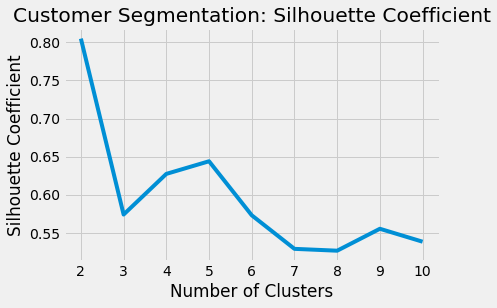

In [8]:
silhouette_coefficients = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(RFM1)
    score = silhouette_score(RFM1, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.title('Customer Segmentation: Silhouette Coefficient')

According to the plot above, 2 clusters give the highest Shihouette Coefficient. The purpose of customer segmentation is to identify a group of loyal customers.  More clusters are preferred as a starting point.  Different clusters can be combined later if needed.  Therefore, the 5 clusters will be used as it has the next highest Silhouette Coefficient.

In [6]:
#kmeans clustering with 5 clusters
kmeans = KMeans(init="random", n_clusters=5, n_init=10, max_iter=300, random_state=42)
Profile6['Clusters'] = kmeans.fit_predict(RFM1)
Cluster_Freq = pd.DataFrame(Profile6['Clusters'].value_counts().reset_index())
Cluster_Freq = Cluster_Freq.sort_values(by=['index'], ascending=True)
Cluster_Freq['Prop'] = Cluster_Freq['Clusters']/Cluster_Freq['Clusters'].sum()

In [12]:
Cluster_Freq

,index,Clusters,Prop
1,0,4150,0.144258
2,1,2197,0.076370
3,2,1502,0.052211
4,3,853,0.029651
0,4,20066,0.697511


Text(0, 0.5, 'No. of Customers')

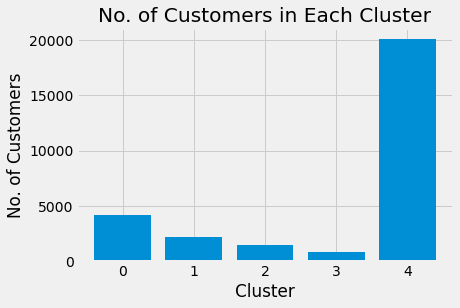

In [13]:
#Bar chart shows number of customers in each cluster
plt.bar(Cluster_Freq['index'], Cluster_Freq['Clusters'])
plt.title('No. of Customers in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('No. of Customers')

Text(0.5, 1.0, 'Proportion of Customers in Each Cluster')

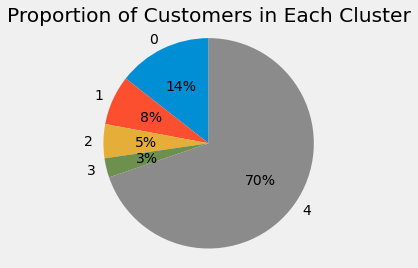

In [14]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
#https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_features.html
labels = Cluster_Freq['index']
sizes = Cluster_Freq['Prop']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.0f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Proportion of Customers in Each Cluster')

There are 5 clusters: 70% of customers are in Cluster 1, Cluster 3 has only 3% of customers.

Text(0.5, 1.0, 'K-means Clustering with 2 dimensions')

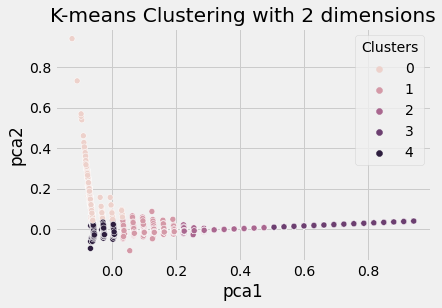

In [15]:
### Run PCA on the data and reduce the no. of dimensions from 4 to 2 in order to show cluster distribution graphically.
reduced_data = PCA(n_components=2).fit_transform(RFM1)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue=Profile6['Clusters'], data=results)
plt.title('K-means Clustering with 2 dimensions')

Cluster 4 is at the lower left corner.  Custers 1, 2 and 3 extend to the right, whereas Cluster 0 extends upwards.  Next, we will explore the characteristics of each cluster.

In [8]:
#Calculate the RFM mean of each cluster
R = pd.DataFrame(Profile6.groupby("Clusters")['RecencyGap'].mean().reset_index())
F = pd.DataFrame(Profile6.groupby("Clusters")['Freq'].mean().reset_index())
D = pd.DataFrame(Profile6.groupby("Clusters")['DDAmt'].mean().reset_index())
L = pd.DataFrame(Profile6.groupby("Clusters")['LoanPayAmt'].mean().reset_index())

Text(0, 0.5, 'Recency Gap')

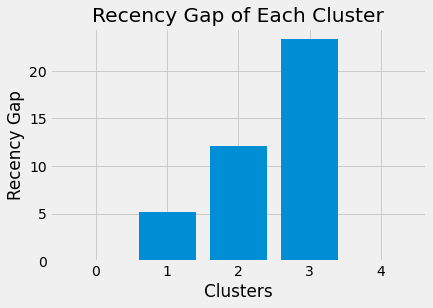

In [17]:
#Bar chart showing the recency gap of each cluster
plt.bar(R['Clusters'], R['RecencyGap'])
plt.title('Recency Gap of Each Cluster')
plt.xlabel('Clusters')
plt.ylabel('Recency Gap')

Clusters 0 and 4 are active customers with almost 0 recency gap, that means they have transactions every month.  The recency gap of customers in Clusters 2 and 3 is high, they are probably dormant customers.

Text(0.5, 1.0, 'Proportion of Monthly Transactions by Clusters')

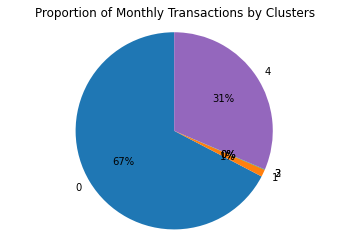

In [10]:
#Frequency Pie Chart
Cluster_Freq = Cluster_Freq.rename({'Clusters':'Count'}, axis=1)
Cluster_Freq = Cluster_Freq.rename({'index':'Clusters'}, axis=1)
F = pd.merge(F, Cluster_Freq, on=['Clusters'])
F['ClusterSum'] = F['Count']*F['Freq']
labels = F['Clusters']
sizes = F['ClusterSum']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.0f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Proportion of Monthly Transactions by Clusters')


Cluster 0 has only 14% customers, it contributes 67% of all monthly transactions.  Cluster 4 has 70% customers and it only contributes 31% of transactions.  The number of monthly transactions among Clusters 1, 2 and 3 is very low.

Text(0.5, 1.0, 'Proportion of Monthly Direct Deposit Amount by Clusters')

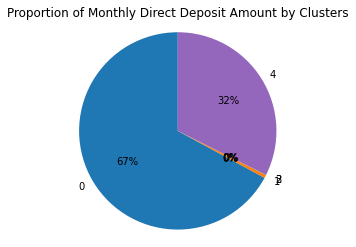

In [11]:
#Direct Deposit Pie Chart
D = pd.merge(D, Cluster_Freq, on=['Clusters'])
D['ClusterSum'] = D['Count']*D['DDAmt']
labels = D['Clusters']
sizes = D['ClusterSum']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.0f%%',
        shadow=False, startangle=90, textprops={'fontsize': 10})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Proportion of Monthly Direct Deposit Amount by Clusters')

Cluster 0 has the highest the amount of direct deposit (67%), Cluster 4 comes second with 32%.  The sum of the other 3 clusters is only 1%.

Text(0.5, 1.0, 'Proportion of Monthly Loan Payment Amount by Clusters')

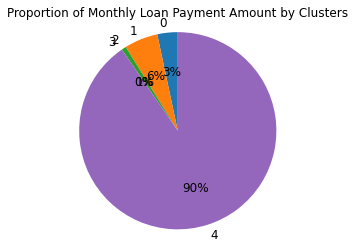

In [12]:
#Loan Payment Pie Chart
L = pd.merge(L, Cluster_Freq, on=['Clusters'])
L['ClusterSum'] = L['Count']*L['LoanPayAmt']
labels = L['Clusters']
sizes = L['ClusterSum']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.0f%%',
        shadow=False, startangle=90, textprops={'fontsize': 12})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Proportion of Monthly Loan Payment Amount by Clusters')

90% of loan payment comes from Cluster 4.  The sum of other clusters is only 10%.  

Customer segmentation through kmeans clutering is able identify the characteristics of different groups of customers.  With this information in hand, companies can target their strategies towards each segment accordingly.  In this example, Clusters 0 and 4 are loyal cuatomers.  They account for 84% of all customers and their combined business volumne is over 90% in terms of monthly transactions, direct deposit amount, as well as loan payment.  Customer retention should be focused on these 2 clusters. Any churner is a loss to the company.

On the other hand, the other 3 clusters are dormant.  They have limited contribution to the bank.  The bank should incentivize them to be more engaging.  